# **Data Cleaning**

## Objectives

* Evaluate missing data
* Correlation and PPS study
* Data Cleaning

## Inputs

* outputs/datasets/collection/house_prices_records.csv
* outputs/datasets/collection/inherited_houses_records.csv

## Outputs

* outputs/datasets/cleaned/train_set.csv
* outputs/datasets/cleaned/test_set.csv
* outputs/datasets/cleaned/clean_house_price_records.csv
* outputs/datasets/cleaned/clean_inherited_houses_records.csv



---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [9]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/project-portfolio-5/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [10]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [11]:
current_dir = os.getcwd()
current_dir

'/workspaces/project-portfolio-5'

# Import Packages

In [12]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from feature_engine.imputation import ArbitraryNumberImputer, CategoricalImputer
from sklearn.pipeline import Pipeline

---

# Load Data

In [13]:
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/house_prices_records.csv")
df.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500


In [14]:
df_inherit = pd.read_csv(f"outputs/datasets/collection/inherited_houses_records.csv")
print(df_inherit.shape)
df_inherit.head(3)

(4, 23)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
0,896,0,2,No,468.0,Rec,270.0,0,730.0,Unf,...,11622,80.0,0.0,0,6,5,882.0,140,1961,1961
1,1329,0,3,No,923.0,ALQ,406.0,0,312.0,Unf,...,14267,81.0,108.0,36,6,6,1329.0,393,1958,1958
2,928,701,3,No,791.0,GLQ,137.0,0,482.0,Fin,...,13830,74.0,0.0,34,5,5,928.0,212,1997,1998


# Data Exploration

Our objective is to get more familiar with the dataset by examining the variable types and distributions, identifying any missing values, and understanding the significance of these variables within a business context.

In [8]:
from pandas_profiling import ProfileReport
pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

# Correlation and PPS Analysis

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps


def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

## Calculate Correlations and Power Predictive Score

In [16]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  552.0  0.055  0.104  0.0  0.0  0.0  0.066  0.702


## Display at Heatmaps



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



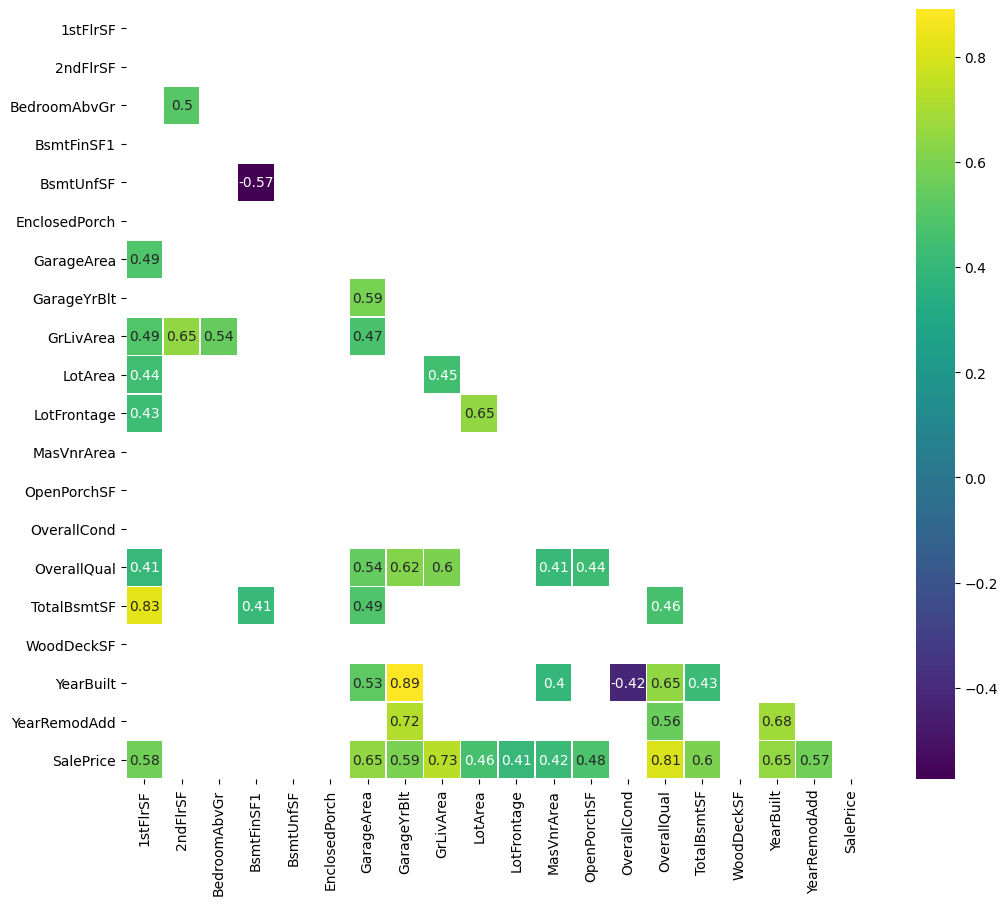



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



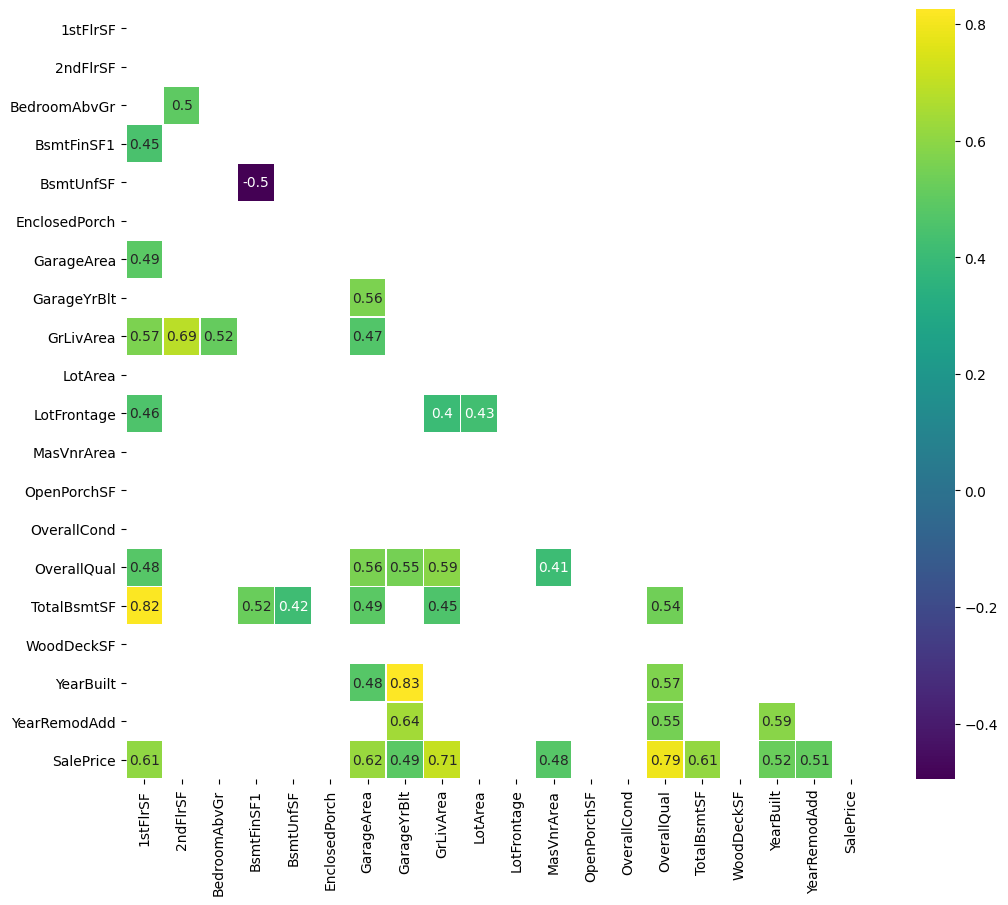



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



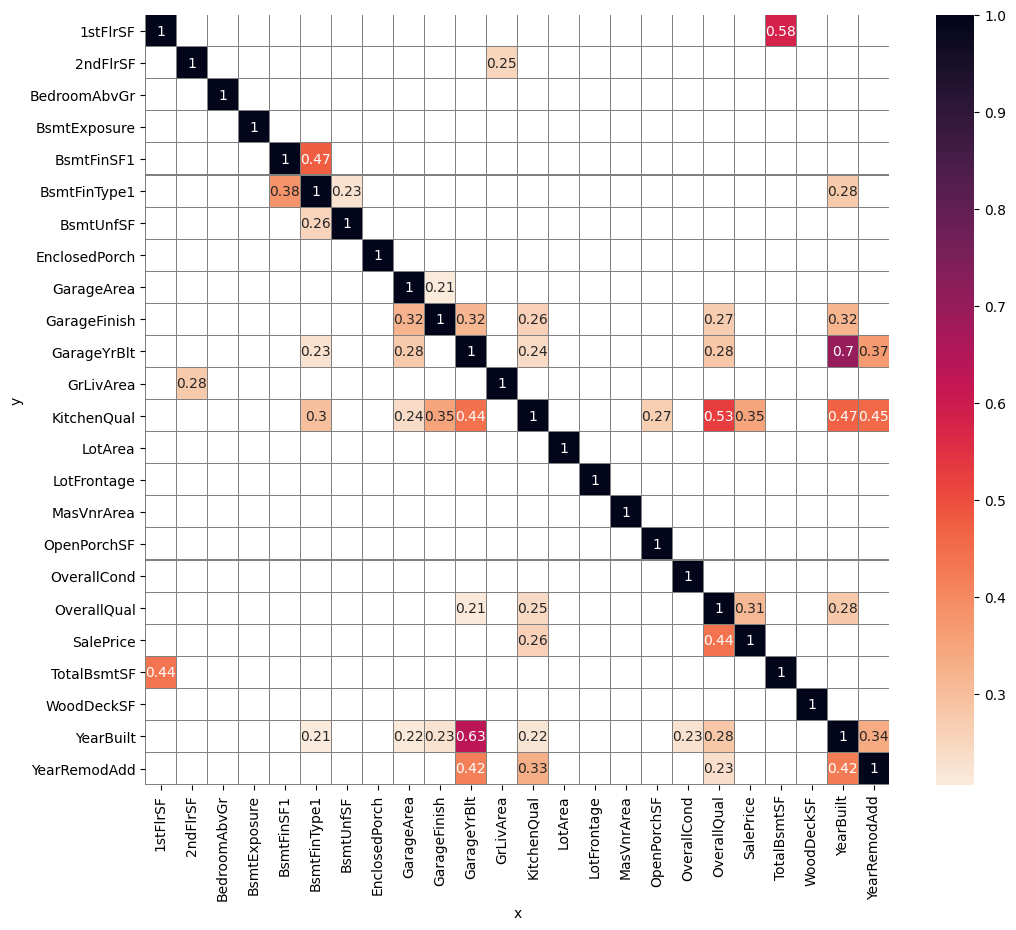

In [17]:
%matplotlib inline

DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)

## Results

OverallQual and GrLivingArea have the highest correlation with SalePrice and both the variables are complete with no missing data.

---

# Data Cleaning

We're going to use the DataCleaningEffect() custom function from the ML Feature Engine lesson to assess the effect of cleaning the data, when imput mean, median or arbitrary number is a numerical variable and to replace with 'Missing' or most frequent a categorical variable

* Parameters: df_original: data not cleaned, df_cleaned: cleaned data,variables_applied_with_method: variables where you applied a given method

In [18]:
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

def DataCleaningEffect(df_original,df_cleaned,variables_applied_with_method):

  flag_count=1 # Indicate plot number
  
  # distinguish between numerical and categorical variables
  categorical_variables = df_original.select_dtypes(exclude=['number']).columns 

  # scan over variables, 
    # first on variables that you applied the method
    # if the variable is numerical plot a histogram, if categorical plot a barplot
  for set_of_variables in [variables_applied_with_method]:
    print("\n=====================================================================================")
    print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
    print(f"{set_of_variables} \n\n")
  

    for var in set_of_variables:
      if var in categorical_variables:  # it is categorical variable: barplot
        
        df1 = pd.DataFrame({"Type":"Original","Value":df_original[var]})
        df2 = pd.DataFrame({"Type":"Cleaned","Value":df_cleaned[var]})
        dfAux = pd.concat([df1, df2], axis=0)
        fig , axes = plt.subplots(figsize=(15, 5))
        sns.countplot(hue='Type', data=dfAux, x="Value",palette=['#432371',"#FAAE7B"])
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.xticks(rotation=90)
        plt.legend() 

      else: # it is numerical variable: histogram

        fig , axes = plt.subplots(figsize=(10, 5))
        sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True,element="step", ax=axes)
        sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True,element="step", ax=axes)
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.legend() 

      plt.show()
      flag_count+= 1

# List of vatiables with missing data

In [19]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

# Dealing with missing data

## Assessing Missing Data Levels

* Custom function to display missing data levels in a DataFrame, it shows the absolute levels, relative levels and data type.

In [20]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data

Check missing data levels for the collected dataset.

In [21]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


## Create clean dataset

From the 9 variables with missing values, we will drop EnclosedPorch and WoodDeckSF as they have more than 80% null values. We will then evaluate the other variables to see if they can be imputed with valid value or median.

## Split Train and Test Set

In [22]:
from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (1168, 24) 
TestSet shape: (292, 24)


In [23]:
df_missing_data = EvaluateMissingData(TrainSet)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 9 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1056,90.41,float64
WoodDeckSF,1034,88.53,float64
LotFrontage,212,18.15,float64
GarageFinish,131,11.22,object
BsmtFinType1,89,7.62,object
BedroomAbvGr,80,6.85,float64
2ndFlrSF,60,5.14,float64
GarageYrBlt,58,4.97,float64
MasVnrArea,6,0.51,float64


## Drop Variables

Due to high percentage of missing values and low predictive power, both 'EnclosedPorch' and 'WoodDeckSF' will be dropped from the dataset.

In [24]:
variables_method = ['EnclosedPorch', 'WoodDeckSF']

print(f"* {len(variables_method)} variables to drop \n\n"
    f"{variables_method}")

* 2 variables to drop 

['EnclosedPorch', 'WoodDeckSF']


In [25]:
from feature_engine.selection import DropFeatures
variables = ['EnclosedPorch', 'WoodDeckSF']
imputer = DropFeatures(features_to_drop=variables)
imputer.fit(TrainSet)
TrainSet, TestSet = imputer.transform(TrainSet), imputer.transform(TestSet)
TrainSet.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
618,1828,0.0,NaN,Av,48,NaN,1774,774,Unf,2007.0,...,11694,90.0,452.0,108,5,9,1822,2007,2007,314813
870,894,0.0,2.0,No,0,Unf,894,308,NaN,1962.0,...,6600,60.0,0.0,0,5,5,894,1962,1962,109500
92,964,0.0,2.0,No,713,ALQ,163,432,Unf,1921.0,...,13360,80.0,0.0,0,7,5,876,1921,2006,163500
817,1689,0.0,3.0,No,1218,GLQ,350,857,RFn,2002.0,...,13265,NaN,148.0,59,5,8,1568,2002,2002,271000
302,1541,0.0,3.0,No,0,Unf,1541,843,RFn,2001.0,...,13704,118.0,150.0,81,5,7,1541,2001,2002,205000


## Variables with Null values

In [26]:
null_variables = TrainSet.columns[TrainSet.isnull().any()].tolist()

## Variables in consideration for transformation or imputation

* LotFrontage and MasVnrArea

In [27]:
TrainSet['LotFrontage'].value_counts().sort_index(ascending=False).head(10)

313.0    1
182.0    1
174.0    1
168.0    1
153.0    1
150.0    1
149.0    1
144.0    1
141.0    1
140.0    1
Name: LotFrontage, dtype: int64

In [28]:
TrainSet['MasVnrArea'].value_counts().sort_index(ascending=False).head(10)

1600.0    1
1378.0    1
1170.0    1
1129.0    1
1115.0    1
1047.0    1
975.0     1
894.0     1
870.0     1
860.0     1
Name: MasVnrArea, dtype: int64

* PPS score and correlation study show that these fields have no predictive power and moderate correlation to SalePrice, so we are going to use MeanMedianImputer to impute a Median value into the null variables.

In [29]:
from feature_engine.imputation import MeanMedianImputer
variables = ['LotFrontage', 'MasVnrArea']
imputer = MeanMedianImputer(imputation_method='median', variables=variables)
imputer.fit(TrainSet)
TrainSet, TestSet = imputer.transform(TrainSet), imputer.transform(TestSet)

In [30]:
EvaluateMissingData(TrainSet)

,RowsWithMissingData,PercentageOfDataset,DataType
GarageFinish,131,11.22,object
BsmtFinType1,89,7.62,object
BedroomAbvGr,80,6.85,float64
2ndFlrSF,60,5.14,float64
GarageYrBlt,58,4.97,float64


EnclosedPorch, WoodDeckSF, LotFrontage and MasVnrArea no longer appear on the list of missing data.

We will now evaluate the remaining 5 variables:

* GarageFinish
* BsmtFinType1
* BedroomAbvGr
* 2ndFlrSF
* GarageYrBlt

## GarageFinish

In [31]:
TrainSet['GarageFinish'].isna().sum()

131

In [32]:
TrainSet['GarageFinish'].value_counts().sort_index()

Fin     254
None     53
RFn     293
Unf     437
Name: GarageFinish, dtype: int64

In [33]:
TrainSet.loc[TrainSet.GarageFinish=="None",'GarageArea'].value_counts()

0    53
Name: GarageArea, dtype: int64

When there is no garage, the value is found to be 0

In [34]:
TrainSet.loc[TrainSet.GarageFinish.isnull(),'GarageArea'].value_counts()

440    5
0      5
308    4
572    3
240    3
      ..
839    1
639    1
471    1
496    1
856    1
Name: GarageArea, Length: 107, dtype: int64

Where GarageFinish is null we can check if GarageArea is 0 and if so we can impute None on GarageFinish, while for the remaining instances we can assume that the garage is not finished and impute Unf to GarageFinish.

In [35]:
query = (TrainSet.GarageArea == 0) & (TrainSet['GarageFinish'].isnull())
TrainSet['GarageFinish'] = np.where(query, 'None', TrainSet['GarageFinish'])

In [36]:
TrainSet['GarageFinish'].isna().sum()

126

In [37]:
pipeline = Pipeline([
      ( 'categorical_imputer', CategoricalImputer(imputation_method='missing',
                                                  fill_value='Unf',
                                                  variables=['GarageFinish']) )
])
pipeline

Pipeline(steps=[('categorical_imputer',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['GarageFinish']))])

In [38]:

pipeline.fit(TrainSet)

TrainSet, TestSet = pipeline.transform(TrainSet), pipeline.transform(TestSet)

In [39]:
TrainSet['GarageFinish'].isna().sum()

0

GarageFinish has now no null values.

## BsmtFinType1

In [40]:
TrainSet['BsmtFinType1'].value_counts().sort_index()

ALQ     159
BLQ     114
GLQ     303
LwQ      52
None     25
Rec     100
Unf     326
Name: BsmtFinType1, dtype: int64

We now inspect BsmtExposure to compare the data.

In [41]:
TrainSet['BsmtExposure'].value_counts().sort_index()

Av      174
Gd      106
Mn       92
No      768
None     28
Name: BsmtExposure, dtype: int64

In [42]:
TrainSet[TrainSet['BsmtFinType1'].isna()].query('BsmtExposure=="None"').sort_values(by=['BsmtExposure'])

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
90,1040,0.0,2.0,None,0,NaN,0,420,Unf,1950.0,...,7200,60.0,0.0,29,5,4,0,1950,1950,109900
736,1040,0.0,2.0,None,0,NaN,0,400,Unf,1949.0,...,8544,60.0,0.0,0,4,3,0,1950,1950,93500
1179,1124,0.0,3.0,None,0,NaN,0,0,None,NaN,...,8335,77.0,0.0,36,5,5,0,1954,1954,93000



Among the properties in the dataset, there are only 25 instances where no basement is present.

Interestingly, the BsmtExposure field does not have any null values. By comparing the two fields, it was determined that there are 3 rows where BsmtExposure is set to "None," indicating the absence of a basement, while BsmtFinType1 is null.

In these specific cases, it is recommended to impute the BsmtFinType1 variable with "None."

In [43]:
query = (TrainSet.BsmtExposure == 'None') & (TrainSet['BsmtFinType1'].isnull())
TrainSet['BsmtFinType1'] = np.where(query, 'None', TrainSet['BsmtFinType1'])

In [44]:
TrainSet['BsmtFinType1'].isna().sum()

86

There are still 86 null values.

BsmtFinType1 also relates to BsmtFinSF1, which rapresents the total finished square feet. We look al BsmtFinSF1 null values where BsmtFinSF1 is 0, meaning 0 finished square feet or that the basement in Unfinished.

In [45]:
df_temp = TrainSet[TrainSet['BsmtFinType1'].isna()].query('BsmtFinSF1==0').sort_values(by=['BsmtFinSF1'])
print(df_temp.shape)
df_temp

(27, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
431,1088,110.0,4.0,No,0,NaN,901,0,None,NaN,...,5586,60.0,0.0,98,7,6,901,1920,1998,79900
1342,1284,885.0,3.0,No,0,NaN,1284,647,RFn,2002.0,...,9375,69.0,149.0,87,5,8,1284,2002,2002,228500
584,989,584.0,3.0,No,0,NaN,884,240,Unf,1935.0,...,6120,51.0,0.0,0,7,4,884,1935,1995,133000
890,672,252.0,NaN,Mn,0,NaN,672,576,Unf,2003.0,...,8064,60.0,0.0,0,7,5,672,1949,2006,122900
573,774,656.0,3.0,No,0,NaN,384,400,RFn,2000.0,...,9967,76.0,0.0,0,5,7,384,2000,2000,170000
653,756,713.0,3.0,No,0,NaN,756,216,Unf,1906.0,...,10320,60.0,0.0,0,7,6,756,1906,1995,135000
248,840,828.0,3.0,No,0,NaN,840,500,RFn,2003.0,...,11317,72.0,101.0,68,5,7,840,2003,2003,180000
1219,672,546.0,3.0,No,0,NaN,672,0,None,NaN,...,1680,21.0,236.0,0,5,6,672,1971,1971,91500
374,847,1081.0,4.0,No,0,NaN,847,434,Fin,2003.0,...,8200,65.0,0.0,48,5,7,847,2003,2004,219500
22,1795,0.0,3.0,No,0,NaN,1777,534,RFn,2002.0,...,9742,75.0,281.0,159,5,8,1777,2002,2002,230000


There is a total of 27 instances where the finished square feet are 0 and the BsmtFinType1 value is null.

We can impute these instances with Unf for BsmtFinType1.

In [46]:
query = (TrainSet.BsmtFinSF1 == 0) & (TrainSet['BsmtFinType1'].isnull())
TrainSet['BsmtFinType1'] = np.where(query, 'Unf', TrainSet['BsmtFinType1'])

In [47]:
TrainSet['BsmtFinType1'].isna().sum()

59

There are still 59 BsmtFinType1 containing nulls. We will be imputing Unk in these remaing null variables, meaning Unknown.

In [48]:

imputer = CategoricalImputer(imputation_method='missing',fill_value='Unk',
                             variables='BsmtFinType1')

imputer.fit(TrainSet)
TrainSet, TestSet, df_clean = imputer.transform(TrainSet), imputer.transform(TestSet), imputer.transform

In [49]:
TrainSet['BsmtFinType1'].isna().sum()

0

BsmtFinType1 has now no null values.

## BedroomAbvGr

In [51]:
TrainSet['BedroomAbvGr'].isna().sum()

80

In [52]:
TrainSet['BedroomAbvGr'].value_counts().sort_index()

0.0      4
1.0     32
2.0    266
3.0    599
4.0    166
5.0     16
6.0      4
8.0      1
Name: BedroomAbvGr, dtype: int64

Imputing the null values with 0 should not affect the sales price analysis, so we prepare the pipeline to impute 0 with ArbitraryNumberImputer.

In [53]:
pipeline = Pipeline([
      ( 'BedroomAbvGr',  ArbitraryNumberImputer(arbitrary_number=0,
                                                variables=['BedroomAbvGr']) )
])
pipeline

Pipeline(steps=[('BedroomAbvGr',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['BedroomAbvGr']))])

In [54]:
pipeline.fit(TrainSet)
TrainSet, TestSet = pipeline.transform(TrainSet), pipeline.transform(TestSet)

In [56]:
TrainSet['BedroomAbvGr'].isna().sum()

0

BedroomAbvGr has now no null values.

# Push files to Repo

* If you do not need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
